In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings 
warnings.filterwarnings('ignore')
import pyarrow.parquet as pq

# **Capstone Project 2**

## **Background**
---
### _**New York Taxi and Limousine Commision (TLC) Trip Record Data**_

The New York City Taxi and Limousine Commission (TLC) is a regulatory agency responsible for overseeing the city's taxi and for-hire vehicle (FHV) services, including yellow cabs, green cabs, and ride-sharing services. Established in 1971, the TLC aims to ensure public safety, regulate fare structures, and promote high standards of service in the transportation industry.

## **Problem Statement**
---

New York City, often referred to as "The Big Apple," is a bustling metropolis known for its vibrant culture, iconic landmarks, and diverse population of over 8 million residents. As a major global hub for business, entertainment, and tourism, NYC attracts millions of visitors each year who flock to experience its renowned attractions, such as Times Square, Central Park, and the Statue of Liberty. The constant influx of tourists, combined with the city's dynamic local population, creates a significant demand for transportation services.

By analyzing taxi's pickup location trends in the first half of 2023, the New York City Taxi and Limousine Commission (TLC) can identify key areas of passenger demand. This insight can be leveraged to optimize taxi operations and enhance revenue generation, ensuring that both residents and visitors have reliable access to transportation throughout the city. From this analysis, arise the **big question**:


-  How can the company analyze **frequent pickup locations** and **common pickup times** to gain insights into passenger demand and **revenue trends** in the first half of 2023, to strategically prepare for expected demand patterns and revenue opportunities in the next 6 months?

The **Key Stakeholders** for this analysis include:

-   Business Department Head: Oversees revenue strategies and operations optimization to meet demand efficiently.
-   NYC TLC Green Cab/Boro Drivers: Benefit directly from increased passenger visibility, enabling targeted and efficient service delivery to high-demand areas.

## **Objectives**
---
To address the big question, the following objectives have been set: 
1. Analyze Peak Pickup Times 
    * Examine patterns in pickup times to understand peak hours, peak days, and demand fluctuations, optimizing scheduling and resource allocation.
1. Identify High-Demand Pickup Locations 
    - Determine the most frequent pickup locations to pinpoint high-demand areas, allowing for strategic driver placement and enhanced service availability.
1. Assess Revenue Trends 
    * Track revenue trends by location and time to identify areas with high revenue potential and support data-driven revenue maximization strategies.

## **Data**
---
### What Is The Data About?

|Column	                | Description                                                                                        |
|---------------        |-----------------------------------------------------------------------------------------------     |
|VendorID	            | Identifier for the taxi vendor, where code 1 represents a taxi from Creative Mobile Tech, and code 2 represents a taxi from VeriFone Inc.        |
|lpep_pickup_datetime	| The date and time when the trip started (the pickup time)                                          |
|lpep_dropoff_datetime	| The date and time when the trip ended (the drop-off time)                                          |
|store_and_fwd_flag	    | Indicates whether the trip data was stored and forwarded (Y = stored, N = not stored)              |
|RatecodeID	            | Numeric code identifying the rate used for the trip fare (1 = Standard rate, 2 = JFK, 3 =  Newark, 4 = Nassau or Westchester, 5 = Negotiated fare, and 6 = Group ride)    |
|PULocationID	        | Pickup location ID, mapped to specific taxi zones or neighborhoods                                 |
|DOLocationID	        | Drop-off location ID, mapped to specific taxi zones or neighborhoods                               |
|passenger_count	    | Number of passengers in the taxi during the trip                                                   |
|trip_distance	        | Distance traveled during the trip, in miles                                                        |
|fare_amount	        | Base fare for the trip, excluding additional charges like tips or tolls                            |
|extra	                | Additional charges (e.g., night surcharge, rush-hour surcharge)                                    |
|mta_tax	            | Metropolitan Transportation Authority (MTA) tax, applicable in certain areas                       |
|tip_amount	            | Amount of tip given by the passenger                                                               |
|tolls_amount	        | Amount of tolls paid during the trip                                                               |
|ehail_fee	            | Fee for e-hailing services (not applicable in this dataset, hence NaN)                             |
|improvement_surcharge	| Surcharge applied for infrastructure improvements, often a flat fee                                |
|total_amount	        | Total amount charged for the trip, including fare, surcharges, taxes, and tips                     |
|payment_type	        | Code indicating the type of payment used (1 = credit card, 2 = cash, 3 = no charge, 4 = dispute, 5 = unknown, 6 = voided trip)                         |
|trip_type	            | Code indicating whether the trip was a street-hail or dispatch trip (1 = street-hail, 2 = dispatch)|
|congestion_surcharge	| Surcharge applied in congested areas during peak traffic hours                                     |

In [4]:
#Import data for the , since we want to identify the most frequent pickup times and locations, and the revenue trend in the first half of 2023
df_jan = pd.read_csv("NYC TLC Trip Record.csv")
df_feb = pd.read_parquet('green_tripdata_2023-02.parquet')
df_mar = pd.read_parquet('green_tripdata_2023-03.parquet')
df_apr = pd.read_parquet('green_tripdata_2023-04.parquet')
df_may = pd.read_parquet('green_tripdata_2023-05.parquet')
df_jun = pd.read_parquet('green_tripdata_2023-06.parquet')



In [5]:
dataframes = [df_jan, df_feb, df_mar, df_apr, df_may, df_jun]

nyc_tlc = pd.concat(dataframes, ignore_index=True)

In [6]:
zone = pd.read_csv('taxi_zone_lookup.csv')
zone

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


The dataset includes location information structured as follows:

* `LocationID`: A unique identifier assigned to each geographical area within the dataset.
* `Borough`: The borough where the location is situated.
* `Zone`: The specific area or neighborhood within the borough.
* `service_zone`: Indicates the service area classification, such as "EWR," "Boro Zone," and "Yellow Zone."

It is found from `Borough` and `Zone` columns there are `Unknown` and `NaN` values, which will be addressed later.

In [7]:
zone['PULocationID'] = zone['LocationID']
zone_PU=zone[['Borough','Zone','PULocationID']]

In [8]:
taxis = pd.merge(nyc_tlc,zone_PU, on='PULocationID', how='left')
taxis = taxis.rename(columns={'Borough': 'PUBorough', 'Zone': 'PUZone'})

The goal of integrating the Zone dataset is to provide location context for the PULocationID in the NYC TLC dataset, which currently uses only numerical identifiers. By mapping these IDs to their corresponding geographical areas, we gain a clearer understanding of pickup patterns, enabling optimized driver placements and improved revenue strategies.

## Data Understanding and Cleaning
---
This process will help us understand the dataset. By following this process, we can identify any anomalies, such as missing value and/or duplicated data within the dataset. Each anomalies that we found, will be cleansed with considerations on domain knowledge, or from a statistical point of view.

First, check for the general info of the dataset:

In [9]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405180 entries, 0 to 405179
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               405180 non-null  int64  
 1   lpep_pickup_datetime   405180 non-null  object 
 2   lpep_dropoff_datetime  405180 non-null  object 
 3   store_and_fwd_flag     377093 non-null  object 
 4   RatecodeID             377093 non-null  float64
 5   PULocationID           405180 non-null  int64  
 6   DOLocationID           405180 non-null  int64  
 7   passenger_count        377093 non-null  float64
 8   trip_distance          405180 non-null  float64
 9   fare_amount            405180 non-null  float64
 10  extra                  405180 non-null  float64
 11  mta_tax                405180 non-null  float64
 12  tip_amount             405180 non-null  float64
 13  tolls_amount           405180 non-null  float64
 14  ehail_fee              0 non-null   

From the current dataset, we can conclude that:

* This dataset consists of 21 columns and 405.180 rows.
* There are missing values in the dataset, specifically in `store_and_fwd_flag`,`RatecodeID`, `passenger_count`, `ehail_fee`, `trip_type`, and `payment_type`.
* For analysis, we can drop these columns with missing values, except for `passenger_count`, which will be retained.

In [10]:
taxis = taxis.drop(columns={'RatecodeID','store_and_fwd_flag','ehail_fee','trip_type','payment_type'})
# These columns are dropped because they are not relevant to the analysis.

In [11]:
# Move PUBorough and PUZone to the right of PULocationID
taxis.insert(taxis.columns.get_loc('PULocationID') + 1, 'PUBorough', taxis.pop('PUBorough'))
taxis.insert(taxis.columns.get_loc('PUBorough') + 1, 'PUZone', taxis.pop('PUZone'))
# Converting into datetime
taxis['lpep_pickup_datetime'] = pd.to_datetime(taxis['lpep_pickup_datetime'])
taxis['lpep_dropoff_datetime'] = pd.to_datetime(taxis['lpep_dropoff_datetime'])

In [12]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(taxis):
    # Remove 'Unknown' values in 'POBorough'
    taxis = taxis[(taxis['PUBorough'] != 'Unknown')]
    # Remove 265 value in PULocationID, as it was being pickup from outside of NYC
    taxis = taxis[taxis['PULocationID'] != 265]
    # Filter out rows where passenger_count exceeds the usual capacity
    taxis = taxis[taxis['passenger_count'] <= 5]
    return taxis

taxis_clean = clean_data(taxis.copy())

In [51]:
# Convert the date time into 24 Hour format, to day and month format, also add trip duration
taxis_clean['pickup_hour'] = taxis_clean['lpep_pickup_datetime'].dt.strftime('%H')
taxis_clean['pickup_day'] = taxis_clean['lpep_pickup_datetime'].dt.day_name()
taxis_clean['trip_duration'] = (taxis_clean['lpep_dropoff_datetime'] - taxis_clean['lpep_pickup_datetime']).dt.total_seconds() / 60
taxis_clean['pickup_month'] = taxis_clean['lpep_pickup_datetime'].dt.strftime('%b')
taxis_clean['average_speed'] = taxis_clean['trip_distance'] / (taxis_clean['trip_duration'] / 60)  

# Rearrange the columns for readability
taxis_clean.insert(taxis_clean.columns.get_loc('lpep_pickup_datetime') + 1, 'pickup_hour', taxis_clean.pop('pickup_hour'))
taxis_clean.insert(taxis_clean.columns.get_loc('pickup_hour') + 1, 'pickup_day', taxis_clean.pop('pickup_day'))
taxis_clean.insert(taxis_clean.columns.get_loc('lpep_dropoff_datetime') + 1, 'trip_duration', taxis_clean.pop('trip_duration'))
taxis_clean.insert(taxis_clean.columns.get_loc('pickup_day') + 1, 'pickup_month', taxis_clean.pop('pickup_month'))
taxis_clean.insert(taxis_clean.columns.get_loc('trip_duration') + 1, 'average_speed', taxis_clean.pop('average_speed'))


In [78]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(taxis_clean_1):
    # Remove Dec and July Month in the Dataset since we're only focusing in Q1-Q2
    taxis_clean_1 = taxis_clean_1[(taxis_clean_1['pickup_month'] != 'Dec') & (taxis_clean_1['pickup_month'] != 'Jul')]
    # Filter out rows where the year is 2009
    taxis_clean_1 = taxis_clean_1[taxis_clean_1['lpep_pickup_datetime'].dt.year == 2023]
    # Remove the trip_duration where it less than 1 minute
    taxis_clean_1 = taxis_clean_1[taxis_clean_1['trip_duration'] >= 1]
    # Remove rows where 'total_amount' is negative
    taxis_clean_1 = taxis_clean_1[taxis_clean_1['total_amount'] >= 0]
    # Remove rows where 'trip_distance' is more than 5000
    taxis_clean_1 = taxis_clean_1[(taxis_clean_1['trip_distance'] <= 500)]
    # Remove rows where 'average_speed' is more than 50
    taxis_clean_1 = taxis_clean_1[(taxis_clean_1['average_speed'] <= 50) & (taxis_clean_1['average_speed'] >=1)]
    

    return taxis_clean_1
taxis_clean.insert(taxis_clean.columns.get_loc('improvement_surcharge') + 1, 'congestion_surcharge', taxis_clean.pop('congestion_surcharge'))

taxis_clean_1 = clean_data(taxis_clean.copy())
taxis_clean_1

,VendorID,lpep_pickup_datetime,pickup_hour,pickup_day,pickup_month,lpep_dropoff_datetime,trip_duration,average_speed,PULocationID,PUBorough,...,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount
0,2,2023-01-01 00:26:10,00,Sunday,Jan,2023-01-01 00:37:11,11.016667,14.051437,166,Manhattan,...,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,2.75,24.18
1,2,2023-01-01 00:51:03,00,Sunday,Jan,2023-01-01 00:57:49,6.766667,16.049261,24,Manhattan,...,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,0.00,15.84
3,1,2023-01-01 00:13:14,00,Sunday,Jan,2023-01-01 00:19:03,5.816667,13.409742,41,Manhattan,...,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,0.00,10.20
4,1,2023-01-01 00:33:04,00,Sunday,Jan,2023-01-01 00:39:02,5.966667,11.061453,41,Manhattan,...,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,0.00,8.00
5,2,2023-01-01 00:53:31,00,Sunday,Jan,2023-01-01 01:11:04,17.550000,9.504274,41,Manhattan,...,1.0,2.78,17.7,1.0,0.5,0.00,0.0,1.0,2.75,22.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399984,2,2023-06-30 23:43:23,23,Friday,Jun,2023-06-30 23:54:32,11.150000,12.484305,95,Queens,...,1.0,2.32,13.5,1.0,0.5,4.80,0.0,1.0,0.00,20.80
399985,2,2023-06-30 21:06:31,21,Friday,Jun,2023-06-30 21:10:34,4.050000,9.629630,145,Queens,...,1.0,0.65,5.8,1.0,0.5,0.00,0.0,1.0,0.00,8.30
399986,2,2023-06-30 23:02:13,23,Friday,Jun,2023-06-30 23:09:48,7.583333,7.991209,74,Manhattan,...,1.0,1.01,9.3,1.0,0.5,0.00,0.0,1.0,0.00,11.80
399987,2,2023-06-30 23:49:09,23,Friday,Jun,2023-06-30 23:54:59,5.833333,10.182857,74,Manhattan,...,1.0,0.99,7.9,1.0,0.5,0.00,0.0,1.0,0.00,10.40


In [58]:
# Detailed Data Information
df_desc = []

for i in taxis_clean_1.columns:
    df_desc.append([i,
                    taxis_clean_1[i].dtypes,
                    taxis_clean_1[i].isna().sum(),
                    round((taxis_clean_1[i].isna().sum()/len(taxis)*100),2),
                    taxis_clean_1[i].nunique(),
                    taxis_clean_1[i].unique()])

df_deepInfo = pd.DataFrame(df_desc, columns = ['Columns', 'dataType', 'null', '% null', 'unique','uniqueSample'])
df_deepInfo

,Columns,dataType,null,% null,unique,uniqueSample
0,VendorID,int64,0,0.0,2,"[2, 1]"
1,lpep_pickup_datetime,datetime64[ns],0,0.0,341974,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
2,pickup_hour,object,0,0.0,24,"[00, 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 1..."
3,pickup_day,object,0,0.0,7,"[Sunday, Monday, Tuesday, Wednesday, Thursday,..."
4,pickup_month,object,0,0.0,6,"[Jan, Feb, Mar, Apr, May, Jun]"
5,lpep_dropoff_datetime,datetime64[ns],0,0.0,341998,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 202..."
6,trip_duration,float64,0,0.0,5066,"[11.016666666666667, 6.766666666666667, 5.8166..."
7,average_speed,float64,0,0.0,156750,"[14.051437216338881, 16.049261083743843, 13.40..."
8,PULocationID,int64,0,0.0,209,"[166, 24, 41, 181, 255, 75, 66, 195, 83, 97, 7..."
9,PUBorough,object,0,0.0,6,"[Manhattan, Brooklyn, Queens, Bronx, Staten Is..."


From the cleaned dataset above, we can conclude that:

* This dataset consists of 22 columns and 347.342 rows.
* There are no more null value found in the dataset.
* The columns `pickup_hour`, `pickup_day`, `pickup_month`, `trip_duration`, and `average_speed` were added to enrich the analysis. These new columns help break down the taxi trip data into more granular components of time and trip details:
    * `pickup_hour` captures the specific hour of day for the trip, allowing us to analyze peak travel times.
    * `pickup_day` identifies the day of the week, helping to detect weekly patterns in taxi usage.
    * `pickup_month` helps assess trends on a monthly basis, especially useful for detecting seasonal variations.
    * `trip_duration` measures how long each trip lasted, which is crucial for understanding trip lengths and potential correlations with fare amounts, traffic patterns, or trip distances.
    * `average_speed` calculates how fast the vehicle traveled on each trip, providing insights into traffic conditions, efficiency of routes, and potential correlations with trip duration and distance. The measurement used here is in miles per hour (mph).

## **Analysis**
---

## **1. Analyze Peak Pickup Times**
Analyze peak pickup times across hours, days, and months. We begin by examining pickup times by hour.

#### **Analyze Peak Pickup Times by Hour**


In [59]:
hourly_pickups = taxis_clean_1.groupby('pickup_hour').size().reset_index(name='pickups_count')

# Set the pickup_hour as the index
hourly_pickups.set_index('pickup_hour', inplace=True)

# Display the resulting DataFrame
hourly_pickups_df = hourly_pickups.sort_values(by='pickups_count', ascending=False)
hourly_pickups_df.head()

,pickups_count
pickup_hour,
18,27974
17,27649
16,26882
15,24965
14,22069


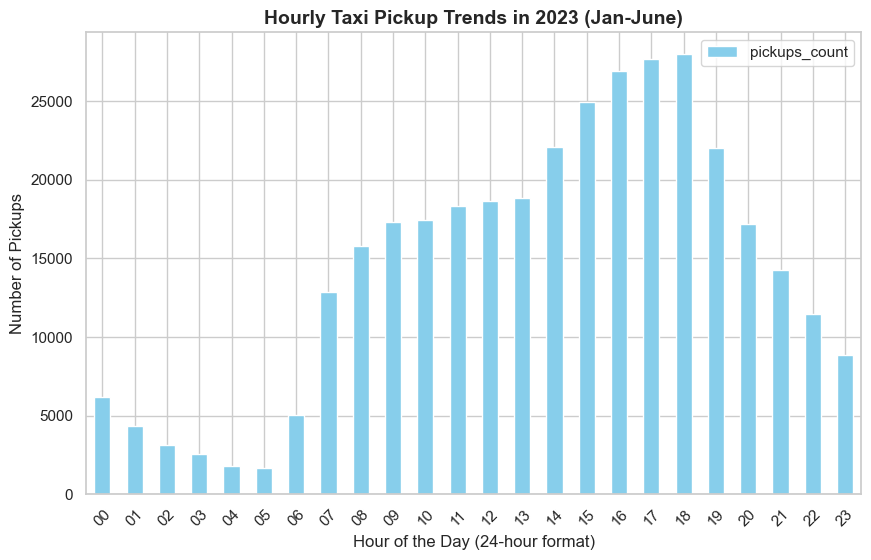

In [74]:
hourly_pickups.plot(kind='bar', color='skyblue', figsize=(10,6))
plt.xlabel('Hour of the Day (24-hour format)')
plt.xticks(rotation=45)
plt.ylabel('Number of Pickups')
plt.title('Hourly Taxi Pickup Trends in 2023 (Jan-June)', fontsize=14, fontweight='bold')
plt.show()

### **Insights:**
1. There's a significant drop in pickups after 12 AM, indicating that fewer people needs rides during off-peak hours.
1. There's a spike starting around 6 AM, suggesting a morning rush likely driven by commuters heading to work, schools, or even to recreational sites during holiday periods.
1. The busiest periods are between 4 PM to 6 PM, peaking around 5-6 PM. This make sense as it's when people are likely heading home after work.

### **Actionable Steps:**
The consistent high demand from 8 AM to 6 PM provides valuable information for the company to optimize their driver schedules. Increase the availability of taxis during the morning rush (6 AM - 9 AM) and evening peak (4 PM - 6 PM).

---

#### **Analyze the hourly pickup trends by Days**

In [61]:
hourly_pickups_daily = taxis_clean_1.groupby(['pickup_day', 'pickup_hour']).size().reset_index(name='pickups_count')

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # Specify the order of the days
hourly_pickups_daily['pickup_day'] = pd.Categorical(hourly_pickups_daily['pickup_day'], categories=days_order, ordered=True)

# Set the pickup_day and pickup_hour as the index
hourly_pickups_daily.sort_values(by=['pickup_day', 'pickup_hour'], inplace=True)
hourly_pickups_daily.set_index(['pickup_day', 'pickup_hour'], inplace=True)
hourly_pickups_daily


pickups_count
pickup_day pickup_hour               
Monday     00                     624
           01                     428
           02                     293
           03                     327
           04                     237
...                               ...
Sunday     19                    2357
           20                    2037
           21                    1758
           22                    1327
           23                    1033

[168 rows x 1 columns]

In [66]:
# Here, we sorted it based on the highest pickups
hourly_pickups_daily_counted = hourly_pickups_daily.copy()
hourly_pickups_daily_counted.sort_values(by=['pickups_count'], ascending=False, inplace=True)

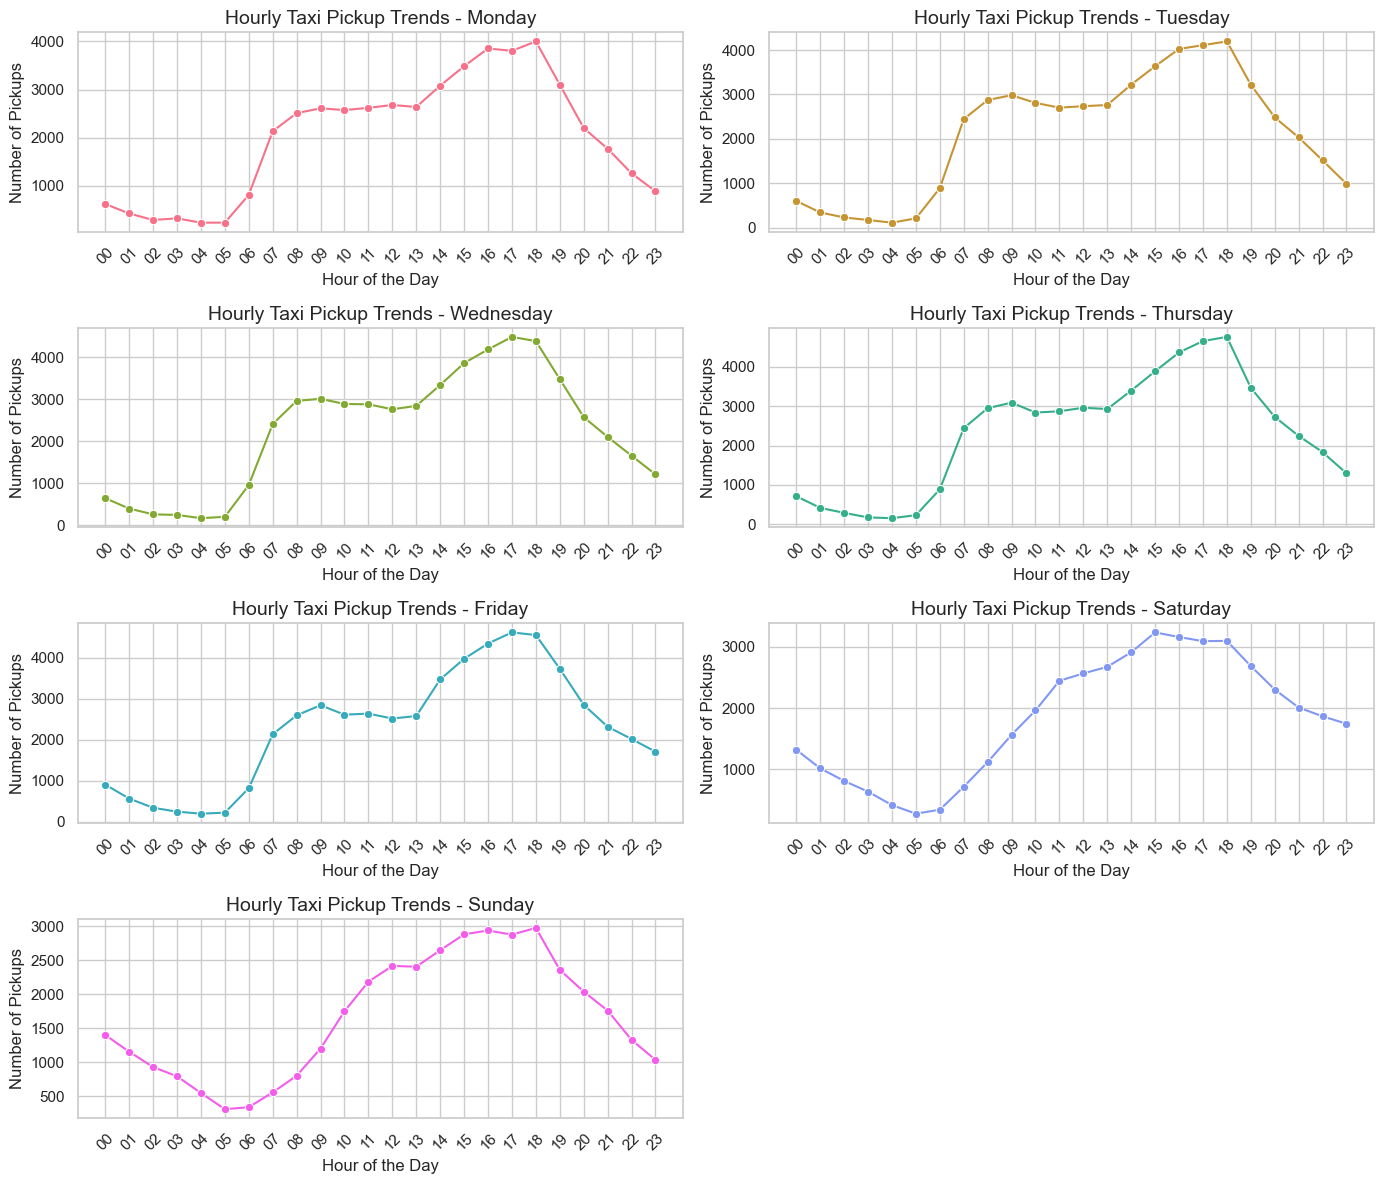

In [91]:
sns.set(style="whitegrid")

# Create subplots: one for each day
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten to easily index the axes

# Colors for each plot
colors = sns.color_palette('husl', len(days_order))

# Iterate over each day and create a separate plot
for i, (day,color) in enumerate(zip(days_order,colors)):
    # Filter data for the current day
    daily_data = hourly_pickups_daily.loc[day].reset_index()
    
    # Plot the data for the current day on the corresponding subplot
    sns.lineplot(ax=axes[i], data=daily_data, x='pickup_hour', y='pickups_count', marker='o', color=color)
    
    # Customize each subplot
    axes[i].set_title(f'Hourly Taxi Pickup Trends - {day}', fontsize=14)
    axes[i].set_xlabel('Hour of the Day', fontsize=12)
    axes[i].set_ylabel('Number of Pickups', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Hide the last subplot if there are not enough days
if len(days_order) < len(axes):
    for j in range(len(days_order), len(axes)):
        fig.delaxes(axes[j])

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

### **Insights:**
1. From Monday to Friday, there's a clear increase in pickups starting at 6 AM, peaking around 5 PM, which aligns with the typical workday commute.
1. The highest number of taxi pickups occurred on Thursday at 6 PM. While it’s understandable that this happened at the end of working hours, driven by people heading home, it's fascinating that it didn't happen on Friday, the end of the weekdays. This suggests that on Friday nights, people might choose to stay out, spending the rest of the evening near their offices, homes, or even at schools and universities, traveling without using taxis. This is supported by the higher number of pickups in the early hours of Saturday, from 12 AM to 4 AM. The same can be said for Sundays, as people stay out late on Saturday nights, then head back home in the early hours of Sunday morning.
1. Saturdays show a later start to increased activity, around 8 AM, with a peak around 3 PM. The pattern is similar on Sundays, but the peak is around 6 PM, indicating a more relaxed start to the day compared to weekdays.  

### **Actionable Steps:**
1. Allocate additional resources and drivers on Thursday evenings to meet the higher demand. Consider offering incentives for drivers willing to work during this peak time.
1. Adjust the start times for drivers on weekend to accommodate the later peak in activity, ensuring that there are enough taxis available when demand increases around 8 AM and peaks at 6 PM.
---


#### **Analyze the hourly pickup trends by Month**

In [67]:
hourly_pickups_monthly = taxis_clean_1.groupby(['pickup_month', 'pickup_hour']).size().reset_index(name='pickups_count')

# Set the month and pickup_hour as the index
hourly_pickups_monthly.set_index(['pickup_month', 'pickup_hour'], inplace=True)

# Display the resulting DataFrame sorted by month and pickup_hour
hourly_pickups_monthly_df = hourly_pickups_monthly.sort_values(by=['pickups_count'], ascending=False)
hourly_pickups_monthly_df.head(10)


pickups_count
pickup_month pickup_hour               
Mar          17                    5178
             18                    5035
             16                    4933
May          18                    4831
Jan          18                    4698
May          17                    4673
Jan          16                    4662
             17                    4608
Jun          18                    4584
Mar          15                    4541

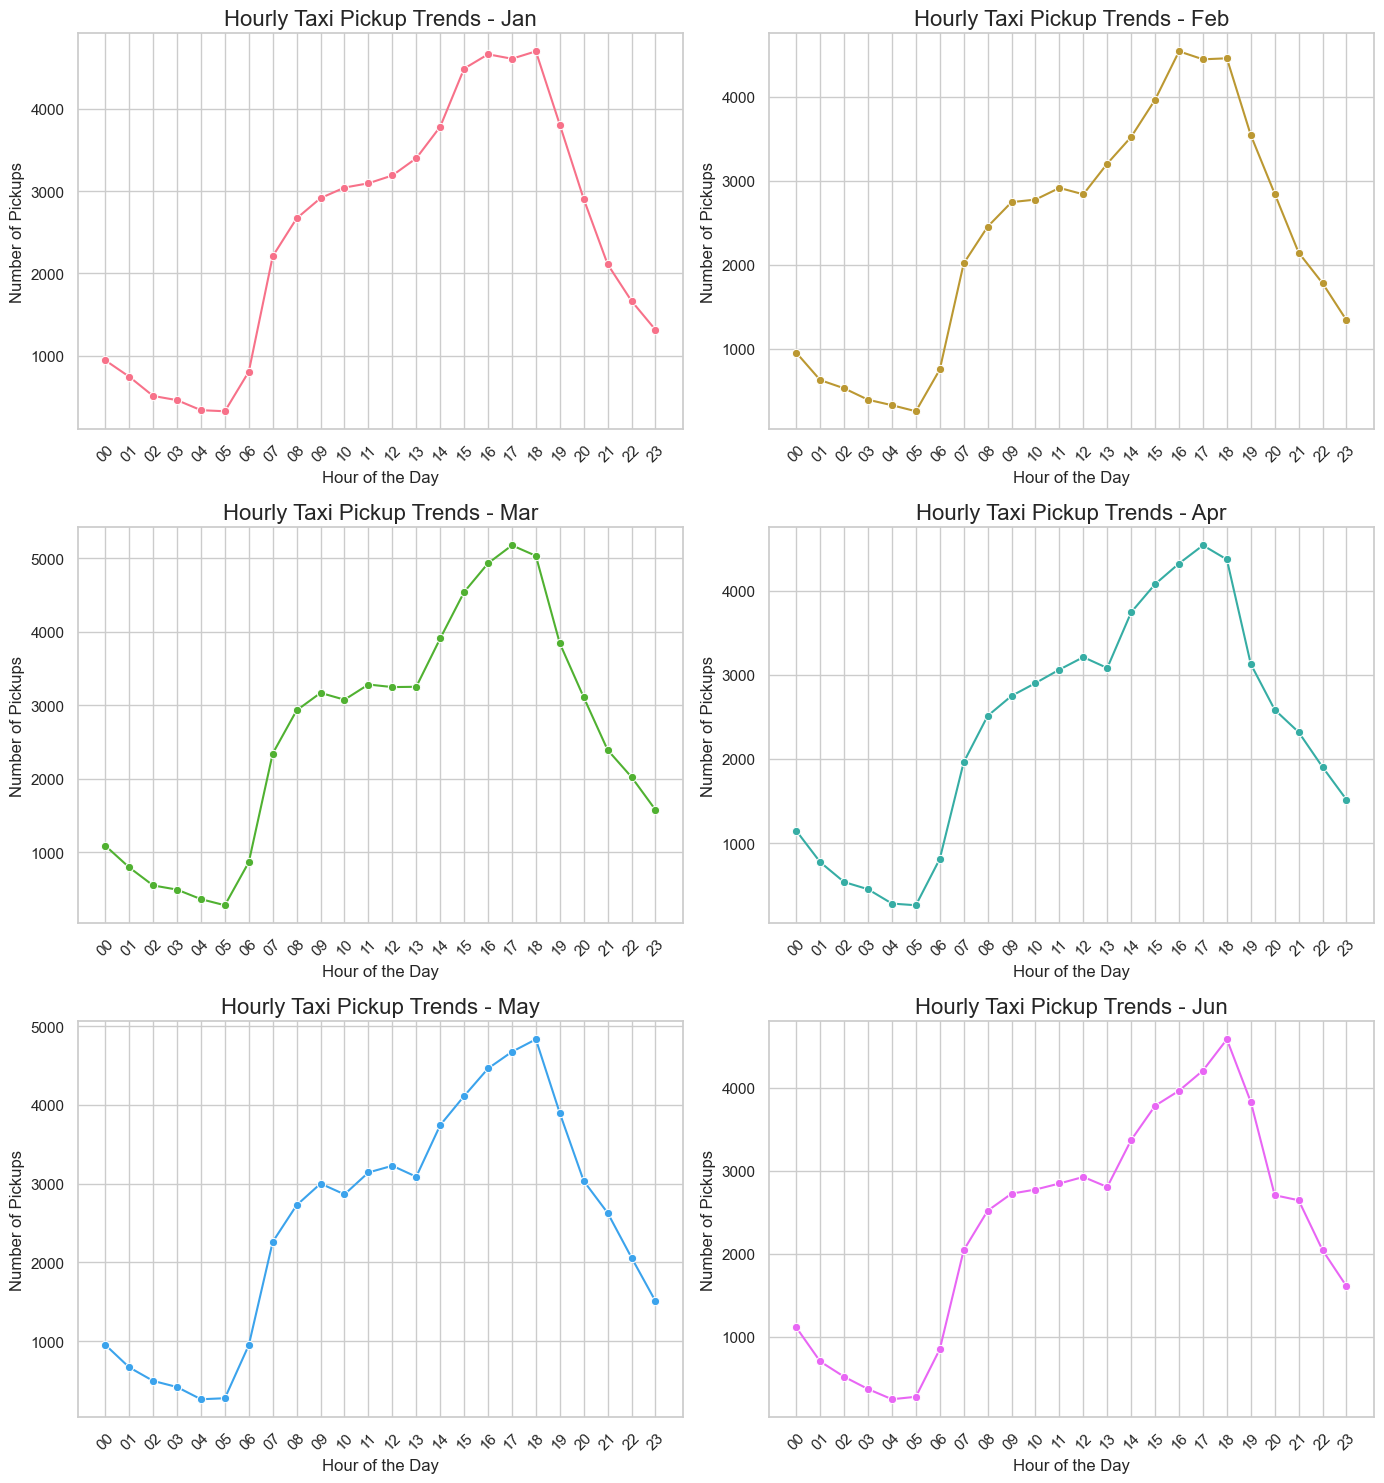

In [68]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a list of unique months to iterate through, and the hours
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
hours_order = [f'{hour:02d}' for hour in range(24)]  # Generates ['00', '01', ..., '23']

# Create subplots: one for each month
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15)) 
axes = axes.flatten()

# Colors for each plot
colors = sns.color_palette('husl', len(months_order))


# Iterate over each month and create a separate plot
for i, (month,color) in enumerate(zip(months_order, colors)):
    # Filter data for the current month
    monthly_data = hourly_pickups_monthly_df.loc[month].reset_index()

    # Convert 'pickup_hour' to a categorical type with the specified order
    monthly_data['pickup_hour'] = pd.Categorical(monthly_data['pickup_hour'], categories=hours_order, ordered=True)
    
    # Plot the data for the current month on the corresponding subplot
    sns.lineplot(ax=axes[i], data=monthly_data, x='pickup_hour', y='pickups_count', marker='o', color=color)
    
    # Customize each subplot
    axes[i].set_title(f'Hourly Taxi Pickup Trends - {month}', fontsize=16)
    axes[i].set_xlabel('Hour of the Day', fontsize=12)
    axes[i].set_ylabel('Number of Pickups', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

### **Insights:**
1. March and May show the highest peaks, suggesting these months have particularly high demand around peak hours.
1. For March, as it was the end of Q1, it can be assumed that the peak pickup at the end of working hours (5-6PM) was influenced by the workload surge, where travel for business purposes was more frequent. This includes client visits and late team meetings, leading to people leaving work later than usual. Additionally, the surge in pickup rates during this hour could also be influenced by recreational sites near the city, such as museums, that close around 5-6 PM
1. While May wasn't the end of Q2, the high pickups during the month can be attributed to a blend of professional and seasonal factors. With spring in full swing, the pleasant weather is perfect for outdoor activities.
1. Surprisingly, June, as the end of Q2, might not carry the same level of urgency or intensity as the end of Q1, which is March. This could mean fewer late-afternoon meetings or client visits, and potentially a smoother transition into the next quarter.
1. Across all months, pickups consistently peak around 5 PM, aligning with the end of the workday rush hour. Activity remains low from midnight to 5 AM, reflecting reduced demand during these early hours.

---


#### **Analyze the total daily pickup**

In [79]:
# Group by 'pickup_day' and count pickups per day
daily_pickups = taxis_clean_1.groupby(['pickup_day']).size().reset_index(name='number_of_pickups_per_day')

# Convert 'pickup_day' column to a categorical type with the specified order
daily_pickups['pickup_day'] = pd.Categorical(daily_pickups['pickup_day'], categories=days_order, ordered=True)

# Sort the DataFrame by the ordered 'pickup_day'
daily_pickups.sort_values('pickup_day', inplace=True)

# Set the 'pickup_day' as the index (optional, if you want the day as the index)
daily_pickups.set_index('pickup_day', inplace=True)

# Display the resulting DataFrame
daily_pickups

,number_of_pickups_per_day
pickup_day,
Monday,48178
Tuesday,51282
Wednesday,53905
Thursday,55553
Friday,54831
Saturday,44004
Sunday,39589


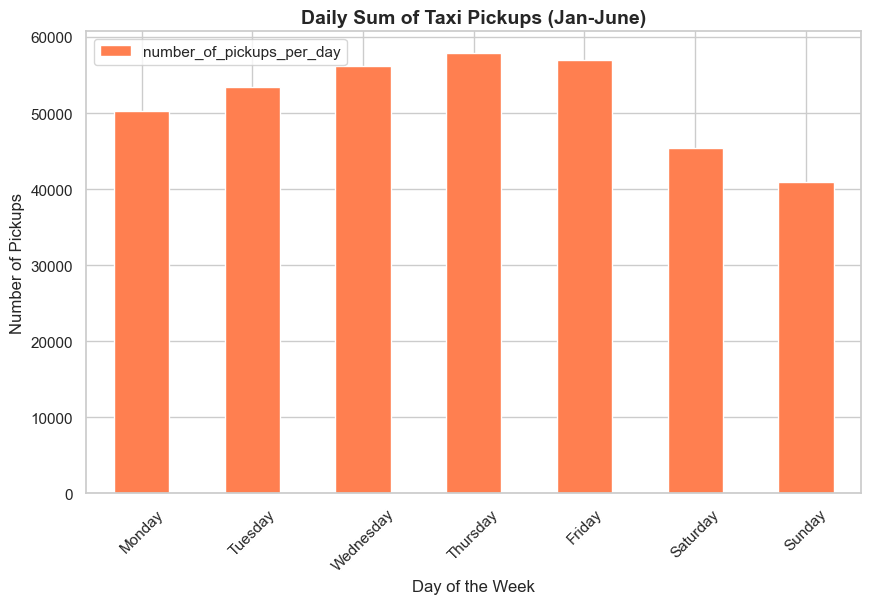

In [73]:
daily_pickups.plot(kind='bar', color='coral', figsize=(10,6))
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.ylabel('Number of Pickups')
plt.title('Daily Sum of Taxi Pickups (Jan-June)', fontsize=14, fontweight='bold')
plt.show()

### **Insights:**
1. The highest number of pickups occurs on Thursday, suggesting that this day has consistently high demand, potentially due to pre-weekend activities or increased business travel.
1. Friday's pickup numbers are strong but slightly lower than Thursday, possibly due to people staying out later and not needing taxis until later in the evening or night.
1. Sunday has the lowest number of pickups, reflecting a typical slowdown as fewer people commute or travel for work. The decrease on Saturday also indicates a shift away from weekday patterns.
---


#### **Analyze daily pickup times, sorted by month**

In [ ]:
# Group the data to get daily pickups per month
monthly_daily_pickups = taxis_clean_1.groupby(['pickup_month', 'pickup_day']).size().reset_index(name='number_of_pickups_per_day')

# Convert 'pickup_month' and 'pickup_day' columns to categorical types with the specified order
monthly_daily_pickups['pickup_month'] = pd.Categorical(monthly_daily_pickups['pickup_month'], categories=months_order, ordered=True)
monthly_daily_pickups['pickup_day'] = pd.Categorical(monthly_daily_pickups['pickup_day'], categories=days_order, ordered=True)

# Sort the DataFrame by the ordered 'pickup_month' and 'pickup_day'
monthly_daily_pickups.sort_values(['pickup_month', 'pickup_day'], inplace=True)

# Set the pickup_month as the index
monthly_daily_pickups.set_index('pickup_month', inplace=True)
monthly_daily_pickups

In [ ]:
# Here, we sorted it based on the highest pickups per day
monthly_daily_pickups_sorted = monthly_daily_pickups.copy()
monthly_daily_pickups_sorted.sort_values(by='number_of_pickups_per_day', ascending=False, inplace=True)

monthly_daily_pickups_sorted.head(10)


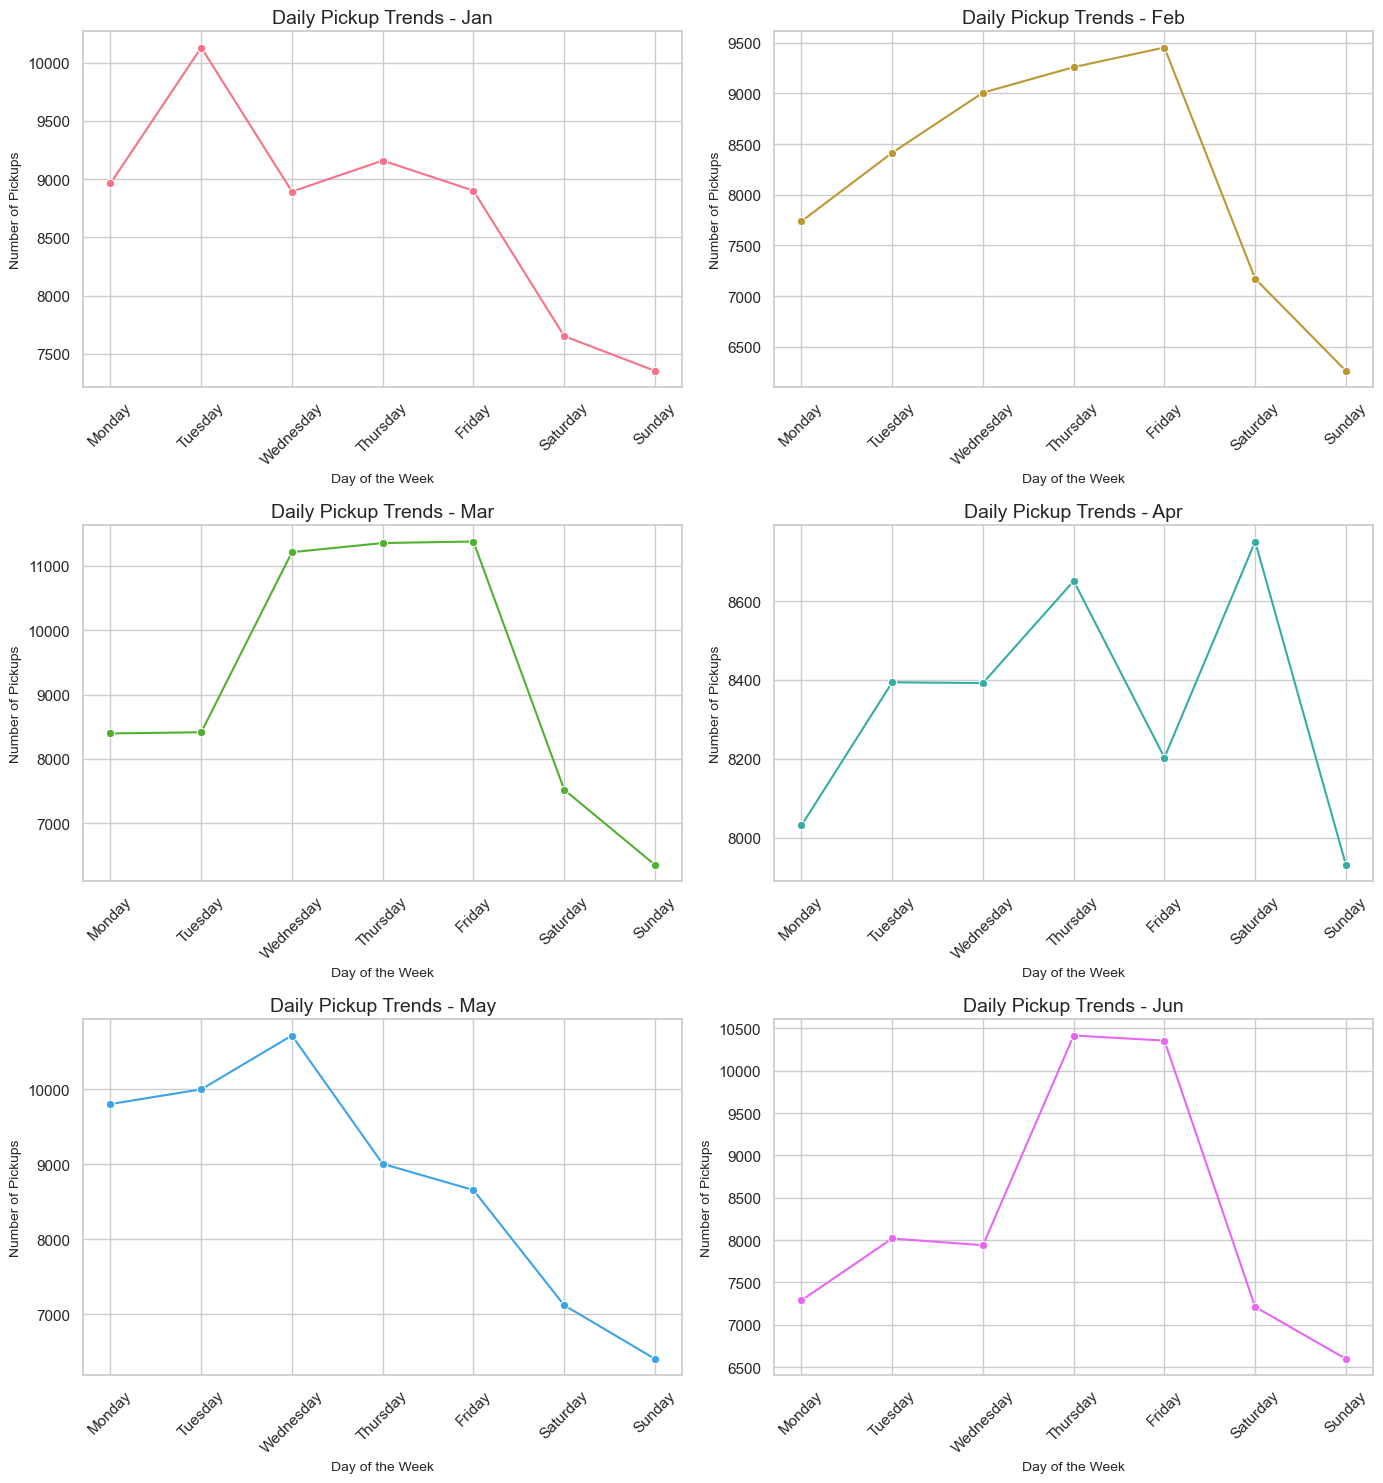

In [35]:
sns.set(style="whitegrid")

# Create subplots: one for each month
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
axes = axes.flatten()

# Colors for each plot
colors = sns.color_palette('husl', len(months_order))

# Iterate over each month and create a separate plot
for i, (month,color) in enumerate(zip(months_order,colors)):
    # Filter data for the current month
    monthly_data = monthly_daily_pickups.loc[month]
    
    # Plot the data for the current month on the corresponding subplot
    sns.lineplot(ax=axes[i], data=monthly_data, x='pickup_day', y='number_of_pickups_per_day', marker='o', color=color)
    
    # Customize each subplot
    axes[i].set_title(f'Daily Pickup Trends - {month}', fontsize=14)
    axes[i].set_xlabel('Day of the Week', fontsize=10)
    axes[i].set_ylabel('Number of Pickups', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

### **Insights:**
1. Pickups tend to peak on weekdays, with specific days varying by month.
1. March stands out with consistently higher pickups across all weekdays, especially from Tuesday to Thursday. This suggests that March is a high-demand month, possibly due to end-of-quarter activities or events in NYC.
1. In June, pickup trends show a stable demand from Thursday to Friday, with the highest demand on Thursday. This pattern indicates a steady mid-week demand, potentially driven by the onset of summer activities, attracting more residents and tourists to the city. However, the increase in June, occurring at the end of Q2, is less pronounced than in March, the end of Q1, which experienced a sharper mid-week peak. This suggests that end-of-quarter activities in March drive more substantial mid-week demand. 

---


#### **Analyze monthly pickup trends**

In [71]:
# Group by 'pickup_month' and count pickups per month
monthly_pickups = taxis_clean_1.groupby('pickup_month').size().reset_index(name='number_of_pickups_per_month')

# Convert 'pickup_month' column to a categorical type with the specified order
monthly_pickups['pickup_month'] = pd.Categorical(monthly_pickups['pickup_month'], categories=months_order, ordered=True)

# Sort the DataFrame by the ordered 'pickup_month'
monthly_pickups.sort_values('pickup_month', inplace=True)

# Set the 'pickup_month' as the index
monthly_pickups.set_index('pickup_month', inplace=True)

# Display the resulting DataFrame
monthly_pickups.sort_values(by='number_of_pickups_per_month', ascending=False)

,number_of_pickups_per_month
pickup_month,
Mar,62233
May,59296
Jan,58696
Apr,56232
Jun,55497
Feb,55388


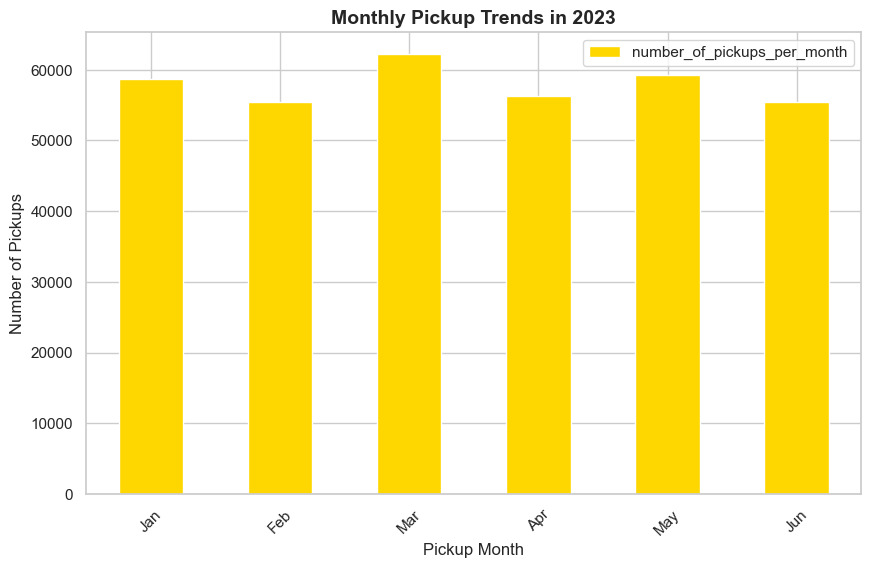

In [85]:
monthly_pickups.plot(kind='bar', color='gold', figsize=(10,6))
plt.xlabel('Pickup Month')
plt.xticks(rotation=45)
plt.ylabel('Number of Pickups')
plt.title('Monthly Pickup Trends in 2023', fontsize=14, fontweight='bold')
plt.show()

### **Insights:**
1. March shows a slightly higher number of pickups compared to other months. This peak could be influenced by specific events or seasonal factors (such as spring break or other large gatherings in the city) leading to increased taxi usage.
1. February has the lowest number of pickups, which could be due to it being a shorter month or possible decreases in outdoor activities due to colder weather. This trend might suggest that taxi demand is marginally affected by month length and possibly weather patterns.

### **Actionable Plan:**

Based on the observed peak in March, marking the end of Q1, NYC TLC could anticipate similar demand surges at the end of Q3 and especially in Q4, coinciding with the holiday season. This pattern suggests that increased pickup demand is likely around December due to Christmas and New Year's Eve celebrations. Using this forecast, NYC TLC can optimize driver allocation by ramping up resources at these critical times to ensure driver availability and meet heightened demand. Proactively managing resources based on quarterly demand trends will help maximize efficiency and potentially boost revenue.

---


## **2. Analyze Most Frequent Pickup Locations**
For the next section, conduct an analysis focused on identifying the most frequent taxi pickup locations.

#### **Monthly Pickup Trends by Pickup Zone**

In [76]:
# Group by month and pickup zone to get the count of pickups
frequent_place = taxis_clean_1.groupby(['pickup_month', 'PUZone']).size().reset_index(name='pickups_count')

# Convert 'pickup_month' to a categorical type with the specified order
frequent_place['pickup_month'] = pd.Categorical(frequent_place['pickup_month'], categories=months_order, ordered=True)

# Set the month and pickup location as the index
frequent_place.set_index(['pickup_month', 'PUZone'], inplace=True)

# Sort the DataFrame by month and then by pickups_count in descending order
frequent_place.sort_values(by=['pickup_month', 'pickups_count'], ascending=[True, False], inplace=True)

# Display the resulting DataFrame
frequent_places = frequent_place.groupby(level=0).head()
frequent_places

pickups_count
pickup_month PUZone                            
Jan          East Harlem North            12193
             East Harlem South             8366
             Forest Hills                  3610
             Central Harlem                3510
             Morningside Heights           3503
Feb          East Harlem North            11006
             East Harlem South             8016
             Morningside Heights           3758
             Central Harlem                3469
             Forest Hills                  3352
Mar          East Harlem North            12841
             East Harlem South             9230
             Morningside Heights           3837
             Central Harlem                3779
             Forest Hills                  3719
Apr          East Harlem North            12405
             East Harlem South             7740
             Morningside Heights           3469
             Central Harlem                3369
             Forest Hills                  3326
May          East Harlem North            13323
             East Harlem South             8207
             Morningside Heights           3575
             Forest Hills                  3441
             Central Harlem                3345
Jun          East Harlem North            12528
             East Harlem South             7423
             Forest Hills                  3344
             Central Harlem                2951
             Morningside Heights           2513

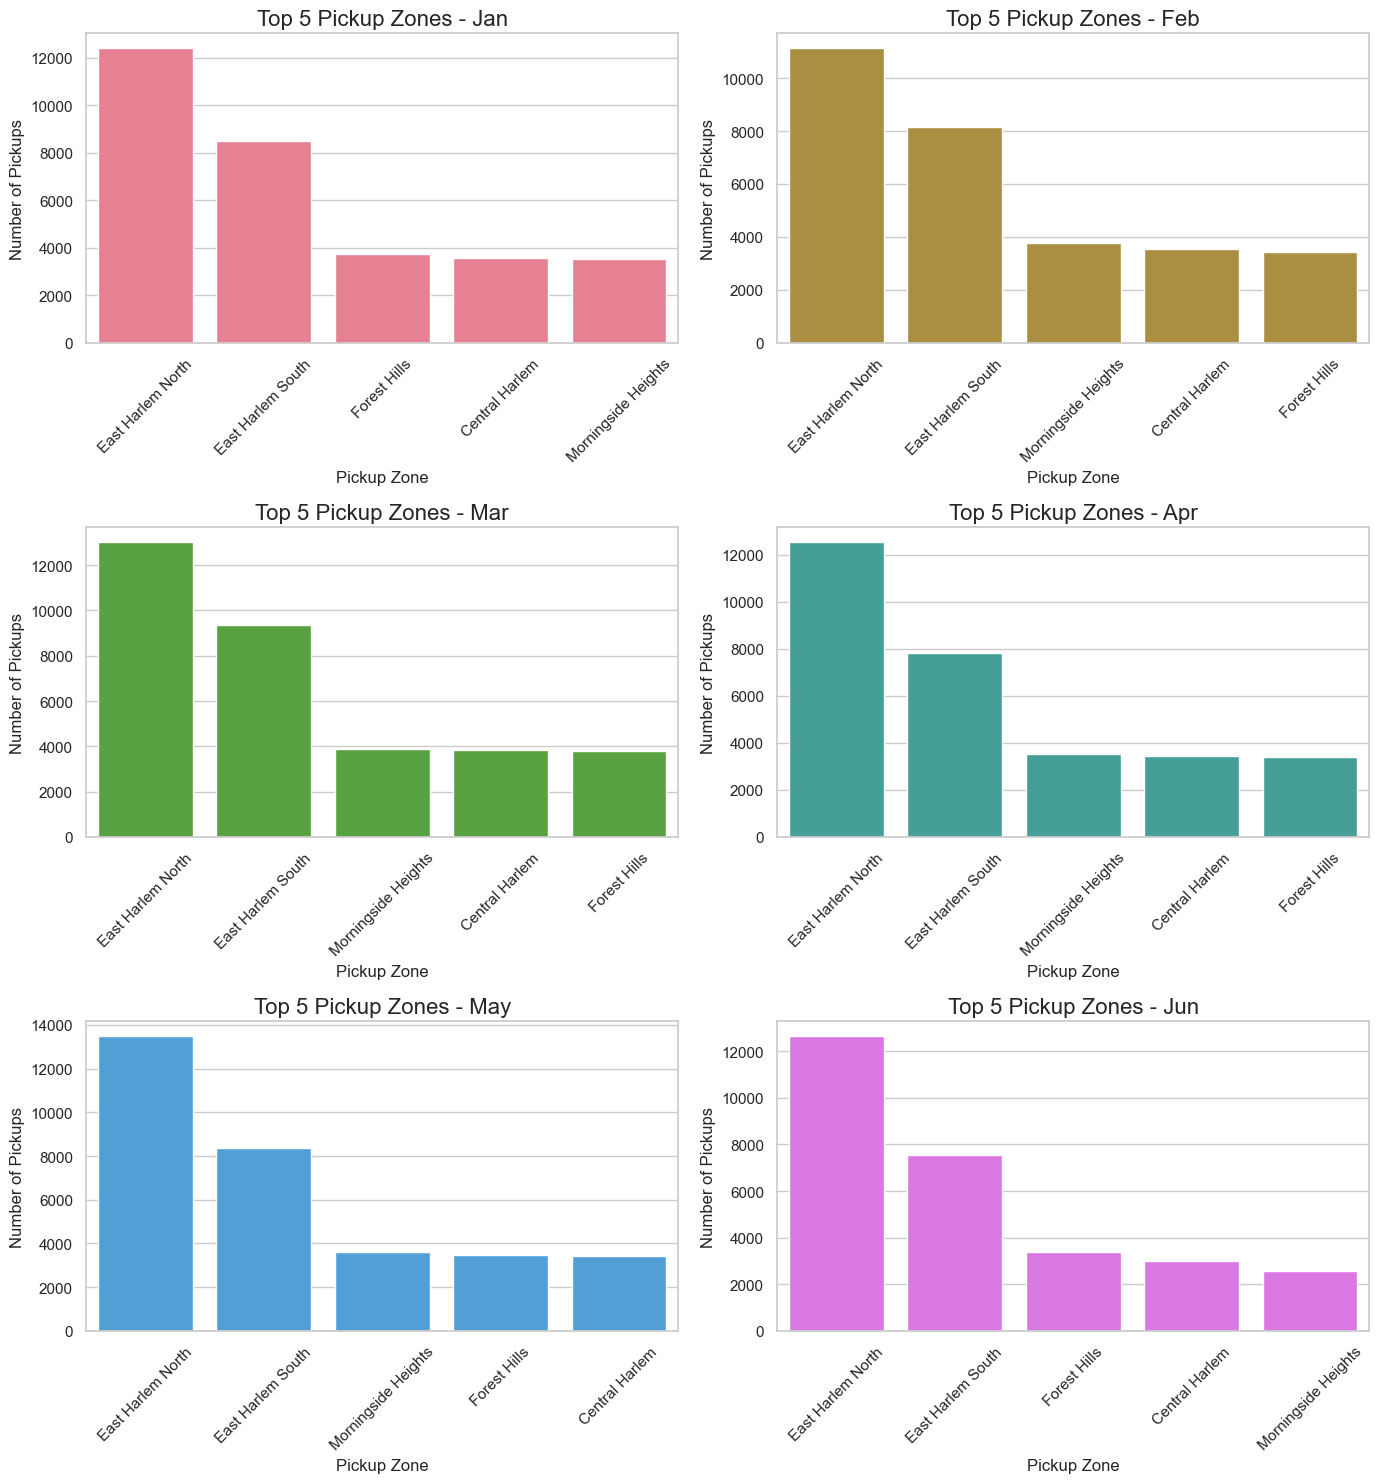

In [39]:
# Create a new DataFrame for plotting
monthly_pickups = frequent_place.reset_index()

# Create subplots: one for each month
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
axes = axes.flatten()

# Set the style for seaborn
sns.set(style="whitegrid")

# Define colors for each month
colors = sns.color_palette("husl", len(months_order))  # Choose a color palette

# Iterate over each month and create a separate plot
for i, month in enumerate(months_order):
    # Filter data for the current month
    monthly_data = monthly_pickups[monthly_pickups['pickup_month'] == month]

    # Get the top 5 pickup zones for the current month
    top_zones = monthly_data.nlargest(5, 'pickups_count')
    
    # Create a bar plot for the top 5 pickup zones on the corresponding subplot
    sns.barplot(ax=axes[i], data=top_zones, x='PUZone', y='pickups_count', palette=[colors[i]])
    
    # Customize the plot
    axes[i].set_title(f'Top 5 Pickup Zones - {month}', fontsize=16)
    axes[i].set_xlabel('Pickup Zone', fontsize=12)
    axes[i].set_ylabel('Number of Pickups', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

### **Insights:**
1. Based on the pickup data from January to June, it was found that the top 5 zones remain the same. East Harlem North consistently leads as the top pickup zone, followed by East Harlem South. Forest Hills, Central Harlem, and Morningside Heights also rank in the top 5, although their positions fluctuate each month.
1. After further analysis, it is found that:
    1. East Harlem, both north and south, has a high population density with many residents living in apartments and rental units. This could also mean more people are likely to use taxis for their daily commute.
    1. East Harlem is home to numerous cultural institutions, such as the Museum of the City of New York, and Grafitti Hall of Fame. These attractions could draw both locals and tourists, increasing the demand for taxis.
    1. The neighborhood boasts a vibrant culinary scene with a variety of restaurants and food markets. Using taxis to travel to and from these dining spots could be more efficient than using the subway or other public transportation.
    1. East Harlem is well-connected to other parts of Manhattan, making it a convenient location for people traveling to work, school, or other activities.
1. Forest Hills, Central Harlem, and Morningside Heights maintain relatively stable pickup numbers, from 2,000 to 4,000 per month, without significant fluctuations.
1. The peak in May suggests a possible seasonal or event-driven surge, with more activity in these prominent areas.
### **Actionable Plan:**    
NYC TLC could increase the driver availability in East Harlem North and South, during the peak hours, to meet the high demand.

---


#### **Total Monthly Visits to Each Pickup Zone**

In [87]:
frequent_place = taxis_clean_1.groupby('PUZone').size().reset_index(name='pickups_count')

# Set the pickup location as the index
frequent_place.set_index('PUZone', inplace=True)

# Display the resulting DataFrame
frequent_place = frequent_place.sort_values(by='pickups_count', ascending=False)
frequent_places = frequent_place.head()
frequent_places

,pickups_count
PUZone,
East Harlem North,74296
East Harlem South,48982
Forest Hills,20792
Morningside Heights,20655
Central Harlem,20423


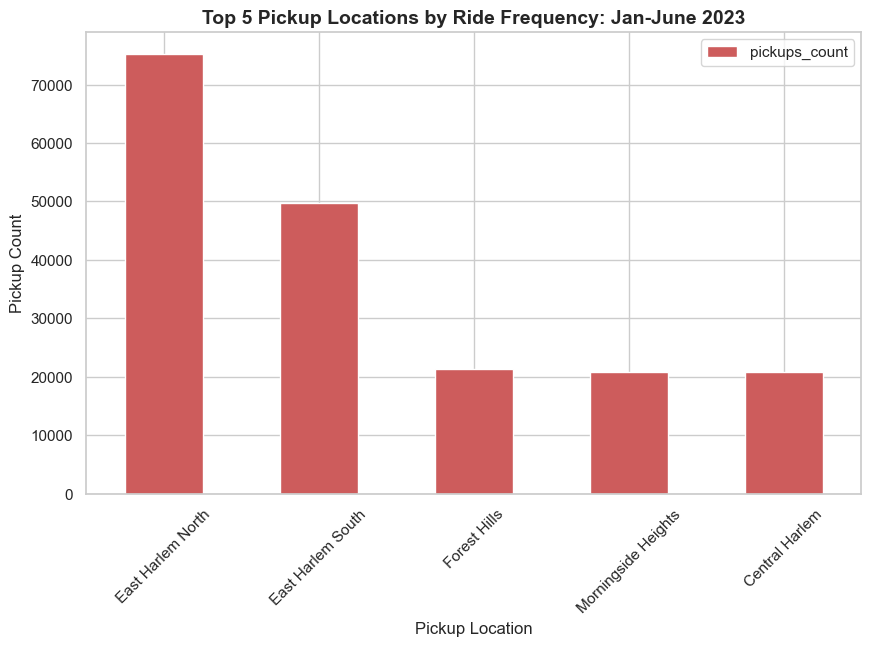

In [42]:
frequent_places.plot(kind='bar', color='indianred', figsize=(10,6))
plt.xlabel('Pickup Location')
plt.xticks(rotation=45)
plt.ylabel('Pickup Count')
plt.title('Top 5 Pickup Locations by Ride Frequency: Jan-June 2023', fontsize=14, fontweight='bold')
plt.show()

### **Insights:**
1. East Harlem North dominates as the top pickup location, with over 70,000 pickups. This area is a clear hotspot for taxi activity.
1. East Harlem South follows with around 50,000 pickups, indicating it’s also a high-demand area, albeit slightly less than its northern counterpart.
1. Central Harlem and Morningside Heights show similar levels of activity, each with about 20,000 pickups. These areas are consistently busy but not to the extent of East Harlem.

---


## **3. Assess Revenue Trends**
In the third section, the analysis focused on the revenue generated each hour and day, organized by month. 

#### **Hourly Revenue Trend Analysis by Day**
For the first analysis, we delve into the daily revenue patterns to uncover fluctuations within each day.



In [88]:
taxis_clean_1['pickup_month'] = pd.Categorical(taxis_clean_1['pickup_month'], categories=months_order, ordered=True)
taxis_clean_1['pickup_day'] = pd.Categorical(taxis_clean_1['pickup_day'], categories=days_order, ordered=True)

# Sum the total_amount for each hour within each day
hourly_revenue_trend = taxis_clean_1.groupby(['pickup_day', 'pickup_hour'])['total_amount'].sum().reset_index()

# Sort the results by day and hour
hourly_revenue_trend = hourly_revenue_trend.sort_values(by=['pickup_day', 'pickup_hour'])

# Set 'pickup_day' and 'pickup_hour' as the index
hourly_revenue_trend.set_index(['pickup_day', 'pickup_hour'], inplace=True)

# Display the result
hourly_revenue_trend


total_amount
pickup_day pickup_hour              
Monday     00               13098.69
           01                9472.91
           02                6272.36
           03                6743.93
           04                5691.51
...                              ...
Sunday     19               48856.35
           20               44885.57
           21               39886.59
           22               29559.94
           23               22812.29

[168 rows x 1 columns]

In [89]:
hourly_revenue_trend_max = hourly_revenue_trend.reset_index()
hourly_revenue_trend_max.sort_values(('total_amount'), ascending=[False])

,pickup_day,pickup_hour,total_amount
89,Thursday,17,112495.68
90,Thursday,18,110970.18
113,Friday,17,110134.36
65,Wednesday,17,108183.00
88,Thursday,16,107535.44
...,...,...,...
75,Thursday,03,4421.90
52,Wednesday,04,4389.00
76,Thursday,04,4013.58
27,Tuesday,03,3868.82


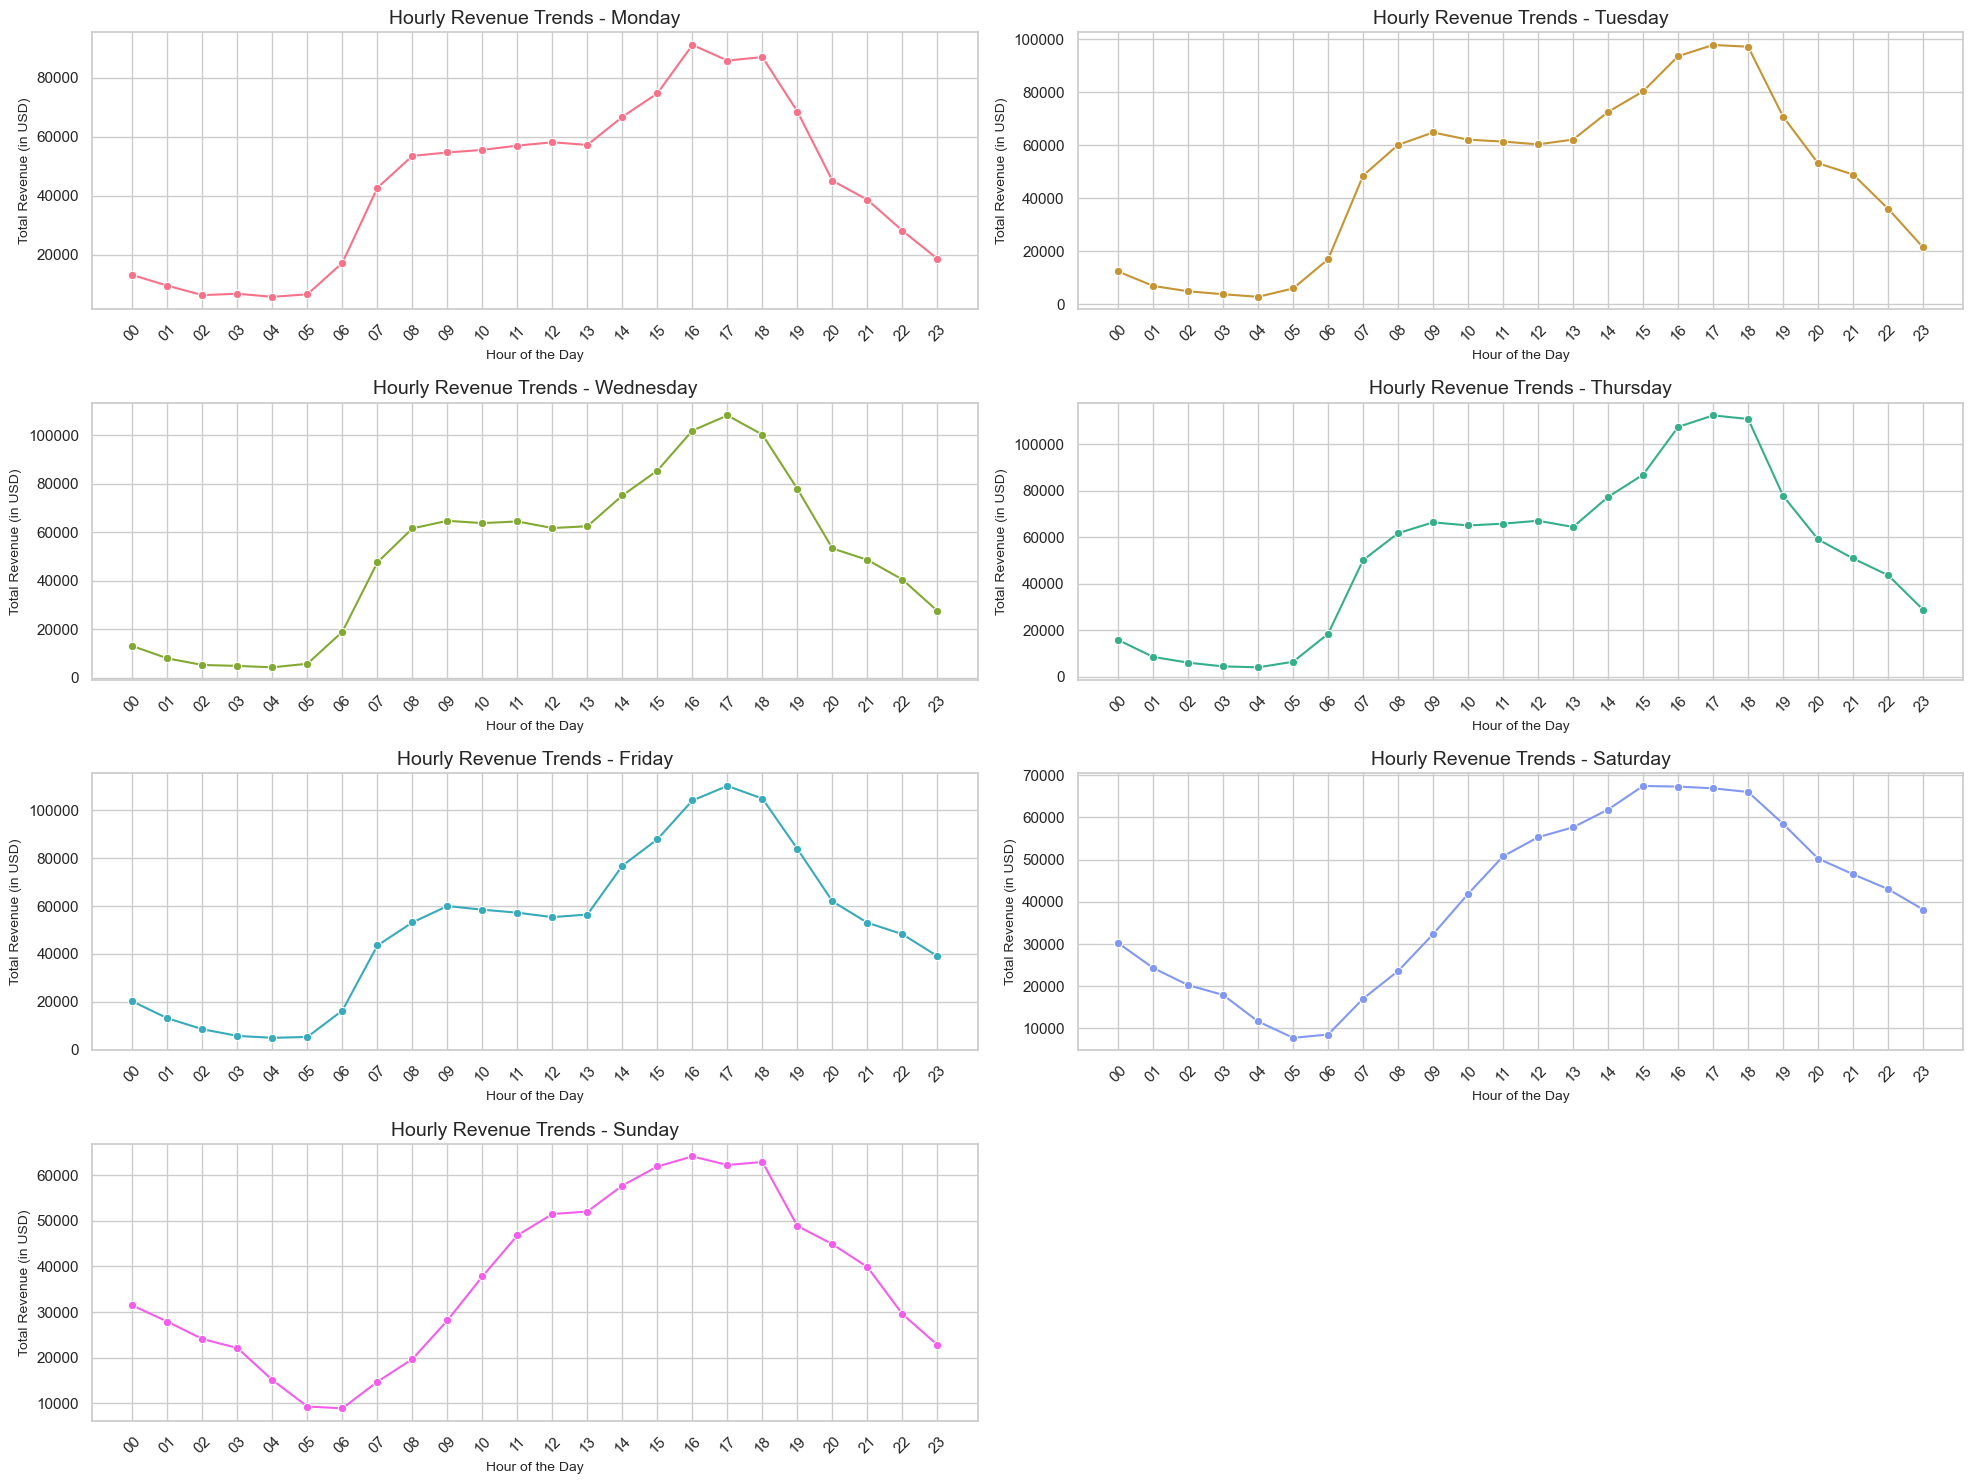

In [94]:
# Create subplots: one for each day
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
axes = axes.flatten()

# Iterate over each day and create a separate plot
for i, (day, color) in enumerate(zip(days_order, colors)):
    # Filter data for the current day
    daily_data = hourly_revenue_trend.loc[hourly_revenue_trend.index.get_level_values('pickup_day') == day]
    
    # Plot the data for the current day on the corresponding subplot
    sns.lineplot(ax=axes[i], data=daily_data, x='pickup_hour', y='total_amount', marker='o', color=color)
    
    # Customize each subplot
    axes[i].set_title(f'Hourly Revenue Trends - {day}', fontsize=14)
    axes[i].set_xlabel('Hour of the Day', fontsize=10)
    axes[i].set_ylabel('Total Revenue (in USD)', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Hide the last subplot if there are not enough days
if len(days_order) < len(axes):
    for j in range(len(days_order), len(axes)):
        fig.delaxes(axes[j])

# Show the plot
plt.show()


### **Insights:**
1. Across all days, there's a noticeable increase in revenue starting early morning (around 5 AM), peaking late afternoon to early evening (around 5 PM to 6 PM). After the peak, revenue generally declines towards the late evening and night.
1. At weekdays (Monday - Friday), high demand consistently peaking around 5-6 PM, aligning with the end of workdays, likely influenced by the evening rush hour.
1. Thursday at 6 PM had the highest revenue compared to other days. This peak suggests a significant demand during the evening rush hour, possibly due to a mix of professional and recreational activities wrapping up for the day.
1. Weekdays have higher peak revenues compared to weekends (Saturday and Sunday). Sunday shows the lowest peak revenue among all days, indicating potentially lower demand for taxis on this day.


---


#### **Daily Revenue Trend Analysis by Month**
For the next analysis, we uncover day-to-day fluctuations within each month.

In [46]:
taxis_clean_1['pickup_month'] = pd.Categorical(taxis_clean_1['pickup_month'], categories=months_order, ordered=True)
taxis_clean_1['pickup_day'] = pd.Categorical(taxis_clean_1['pickup_day'], categories=days_order, ordered=True)

# Sum the total_amount for each day within each month
daily_monthly_revenue = taxis_clean_1.groupby(['pickup_month', 'pickup_day'])['total_amount'].sum().reset_index()

# Sort the results by month and day
daily_monthly_revenue = daily_monthly_revenue.sort_values(by=['pickup_month', 'pickup_day'])

# Set 'pickup_month' and 'pickup_day' as the index
daily_monthly_revenue.set_index(['pickup_month', 'pickup_day'], inplace=True)

# Display the result
daily_monthly_revenue.head()


total_amount
pickup_month pickup_day              
Jan          Monday         189386.54
             Tuesday        217593.98
             Wednesday      189154.71
             Thursday       198226.53
             Friday         190372.19

In [ ]:
daily_monthly_revenue_reset = daily_monthly_revenue.reset_index()
daily_monthly_revenue_reset

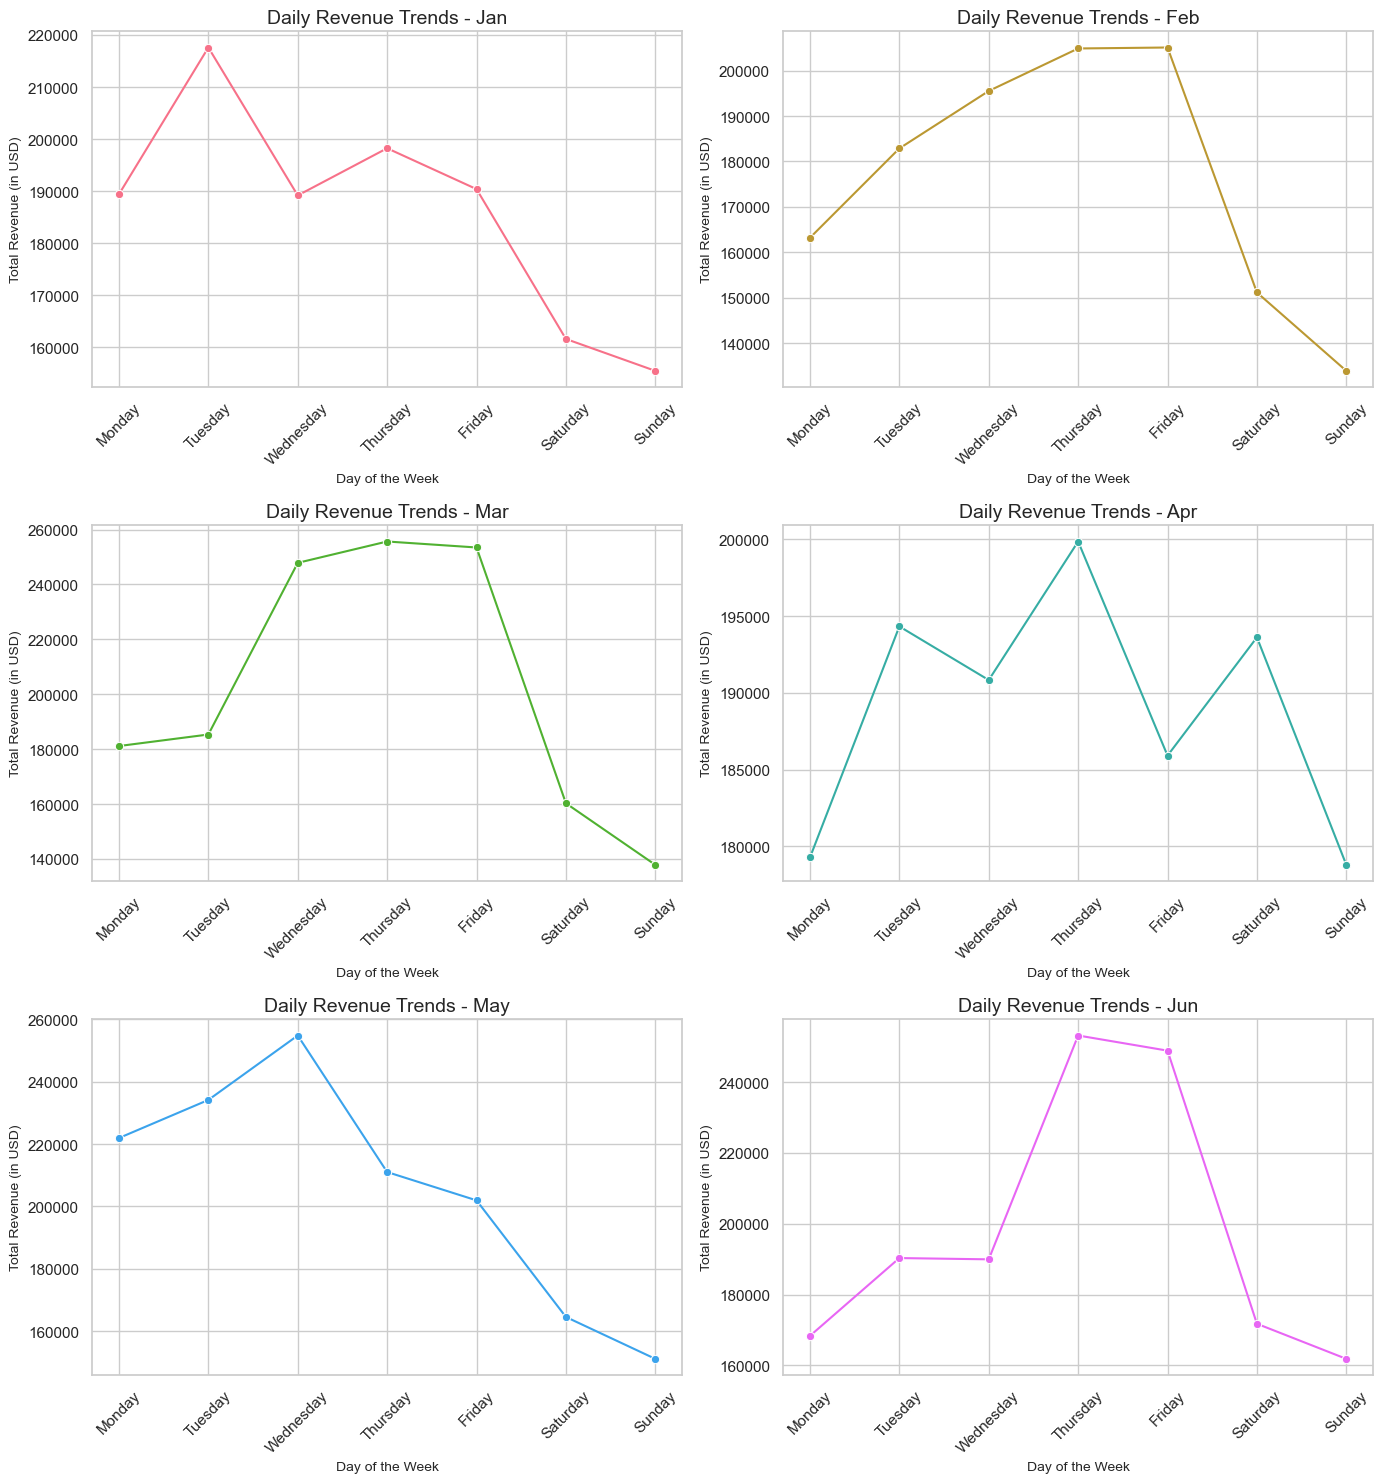

In [48]:
sns.set(style="whitegrid")

# Create subplots: one for each month
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
axes = axes.flatten()

# Colors for each plot
colors = sns.color_palette('husl', len(months_order))

# Iterate over each month and create a separate plot
for i, (month, color) in enumerate(zip(months_order, colors)):
    # Filter data for the current month
    monthly_data = daily_monthly_revenue.loc[month]
    
    # Plot the data for the current month on the corresponding subplot
    sns.lineplot(ax=axes[i], data=monthly_data, x='pickup_day', y='total_amount', marker='o', color=color)
    
    # Customize each subplot
    axes[i].set_title(f'Daily Revenue Trends - {month}', fontsize=14)
    axes[i].set_xlabel('Day of the Week', fontsize=10)
    axes[i].set_ylabel('Total Revenue (in USD)', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()


### **Insights:**
1. Revenue tends to peak midweek (Tuesday to Thursday) across all months.
1. Thursday often shows the highest revenue, indicating higher demand midweek.
1. Noticeable decline in revenue towards the weekend, particularly from Friday to Sunday.

### **Actionable Plan:**

Train drivers on the importance of being available during peak hours, particularly at the end of the workday. Additionally, ensure availability on Thursdays, which often have the highest demand. Consider providing incentives for working during high-demand periods.

---


#### **Monthly Revenue Analysis**
A concise overview of monthly revenue trends and patterns for the first half of 2023.

In [86]:
taxis_clean_1['pickup_month'] = pd.Categorical(taxis_clean_1['pickup_month'], categories=months_order, ordered=True)

# Now, let's sum all the total_amount for each month, and sort them
monthly_total = taxis_clean_1.groupby('pickup_month')['total_amount'].sum().reset_index()

# Sort the results by month
monthly_total = monthly_total.sort_values(by='pickup_month')

# Set the 'pickup_month' as the index
monthly_total.set_index('pickup_month', inplace=True)

# Display the result
monthly_total

,total_amount
pickup_month,
Jan,1242350.05
Feb,1186554.24
Mar,1359448.23
Apr,1261648.84
May,1373283.72
Jun,1316975.14


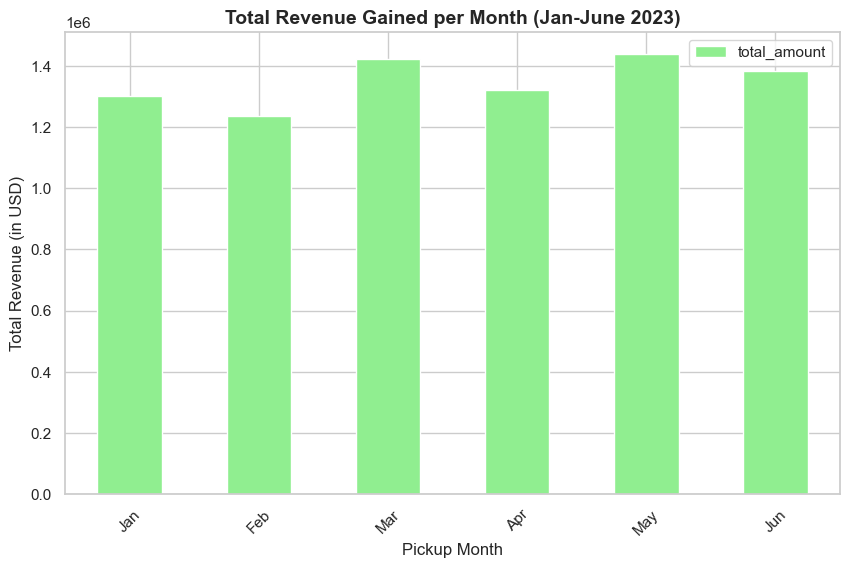

In [77]:
monthly_total.plot(kind='bar', color='lightgreen', figsize=(10,6))
plt.xlabel('Pickup Month')
plt.xticks(rotation=45)
plt.ylabel('Total Revenue (in USD)')
plt.title('Total Revenue Gained per Month (Jan-June 2023)', fontsize=14, fontweight='bold')
plt.show()

### **Insights:**
1. The total revenue is relatively stable, ranging between 1.2 million and 1.4 million USD each month. This stability suggests a steady demand for taxi services.
1. March and May lead the pack with approximately 1.4 million USD in total revenue, indicating particularly strong performance during these months.
1. February stands out as the month with the lowest revenue, just above 1.2 million USD. This dip might be attributed to shorter days, weather conditions, or fewer events.
1. Q1 (Jan-Mar) and Q2 (Apr-Jun) show consistent performance without significant fluctuations, reflecting a stable business environment over these periods.
1. The high revenue in March aligns with the end-of-quarter rush in Q1, where increased business activities might have driven up taxi demand.
1. The significant revenue in May could be attributed to a combination of professional activities, seasonal events, and favorable weather conditions, encouraging more outdoor activities and travel. 


---


## **Conclusion and Recomendation**
---

### **Conclusion**

The data reveals consistent high demand for pickups from 8 AM to 6 PM on weekdays, with morning and evening rush hours especially busy, reflecting the influence of commuter traffic patterns. Demand peaks noticeably on Thursday evenings, likely due to additional end-of-week activities. Weekends show a distinct pattern with demand surging later in the morning and extending into the evening, likely aligning with leisure schedules. Furthermore, quarterly demand surges are evident, as seen with the peak in March (end of Q1), suggesting that similar increases may occur at the end of Q3 and Q4, especially around the holiday season and end-of-year festivities. Certain locations, such as East Harlem North and South, exhibit particularly high demand during peak hours, underscoring opportunities for targeted driver allocation in these areas. To maximize operational efficiency, it is essential that drivers are aware of these peak times and high-demand locations. Incentives can also encourage drivers to be available during these crucial periods, helping the company meet passenger demand effectively while retaining driver engagement.

### **Recomendation**
Preparing for the transition into Q3 and later to Q4, the NYC TLC can improve many aspects based on the insights and findings. These recommendations are:
1. Increase driver availability during the morning rush (6 AM - 9 AM) and evening peak (4 PM - 6 PM), ensuring sufficient coverage to meet demand. Modify driver start times on weekends to align with later peak activity, ensuring availability around 8 AM and peaking at 6 PM.
1. Allocate additional drivers and resources on Thursday evenings to handle higher demand effectively. Consider providing incentives for drivers working during this peak time.
1. Enhance driver availability in East Harlem North and South during peak hours to cater to high demand.
1. Prepare for demand surges at the end of Q3 and Q4, particularly around the holiday season in December, by ramping up resources and driver availability.
